In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import missingno as mn
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from pycaret.classification import setup, compare_models, plot_model, create_model, tune_model, predict_model, stack_models, save_model, load_model
from sklearn.metrics import f1_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import LearningCurve

In [2]:
data = pd.read_csv('Fraud_Detection.csv')
data_orig = data.copy()

# EDA

### Basic Inspection

In [3]:
data.sample(5)

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
68664     36   PAYMENT    7727.18  C1289677675            0.0            0.00   
533883   374   PAYMENT   47406.73   C444389096        65273.0        17866.27   
294113   230  CASH_OUT  246958.03   C937252187            0.0            0.00   
219980   186  CASH_OUT    1022.67  C1533502754         2974.0         1951.33   
183110   163  CASH_OUT   16344.96  C2083104707        20530.0         4185.04   

           nameDest  oldbalanceDest  newbalanceDest  isFraud  
68664   M1107907500            0.00            0.00        0  
533883  M1704230978            0.00            0.00        0  
294113  C1604241615      1150144.81      1397102.85        0  
219980   C977888667       646935.78       647958.45        0  
183110  C1855075966       386538.93       402883.89        0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            636262 non-null  int64  
 1   type            636262 non-null  object 
 2   amount          636262 non-null  float64
 3   nameOrig        636262 non-null  object 
 4   oldbalanceOrg   636262 non-null  float64
 5   newbalanceOrig  636262 non-null  float64
 6   nameDest        636262 non-null  object 
 7   oldbalanceDest  636262 non-null  float64
 8   newbalanceDest  636262 non-null  float64
 9   isFraud         636262 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 48.5+ MB


In [5]:
data.shape

(636262, 10)

- `step`: Maps a unit of time in the real world. In this case 1 step is 1 hour of time.
- `type`: CASH_IN, CASH_OUT, DEBIT, PAYMENT and TRANSFER.
- `amount`: Amount of the transaction in local currency.
- `nameOrig`: Customer who started the transaction.
- `oldbalanceOrg`: Initial balance before the transaction.
- `newbalanceOrig`: Customer's balance after the transaction.
- `nameDest`: Recipient ID of the transaction.
- `oldbalanceDest`: Initial recipient balance before the transaction.
- `newbalanceDest`: Recipient's balance after the transaction.
- `isFraud`: Identifies a fraudulent transaction (1) and non fraudulent (0).

In [6]:
# make column names uniform
data = data.rename(columns = {'oldbalanceOrg': 'oldbalanceOrig'})

### Detailed Inspection

In [7]:
pp.ProfileReport(data)

Since `nameOrig` and `nameDest` have high cardinality and are uniformly distributed, they are not useful for fraud detection. It is safe to drop these $2$ features. Besides, `oldbalanceOrig`, `newbalanceOrig`, `oldbalanceDest` and `newbalanceDest` respectively contain more than $30\%$ zeros. It requires some inspections about whether these zeros are actually missing values.

**Categorical Feature**

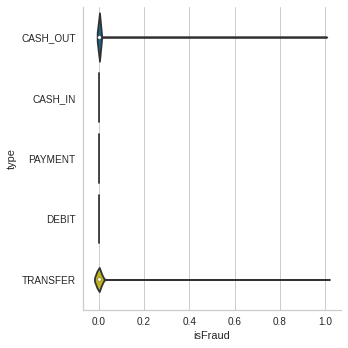

In [8]:
sns.catplot(x = "isFraud", y = "type", kind = "violin", data = data)
pass

In [9]:
data[data['type'].isin(['CASH_IN', 'PAYMENT', 'DEBIT']) & data['isFraud'] == 1]

Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrig, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud]
Index: []

Therefore, the fraud only appears when `type` is either 'CASH_OUT' or 'TRANSFER'. When `type` is 'CASH_IN', 'PAYMENT' or 'DEBIT', the outcome `isFruad` can be predicted as $0$.

**Continuous Features**

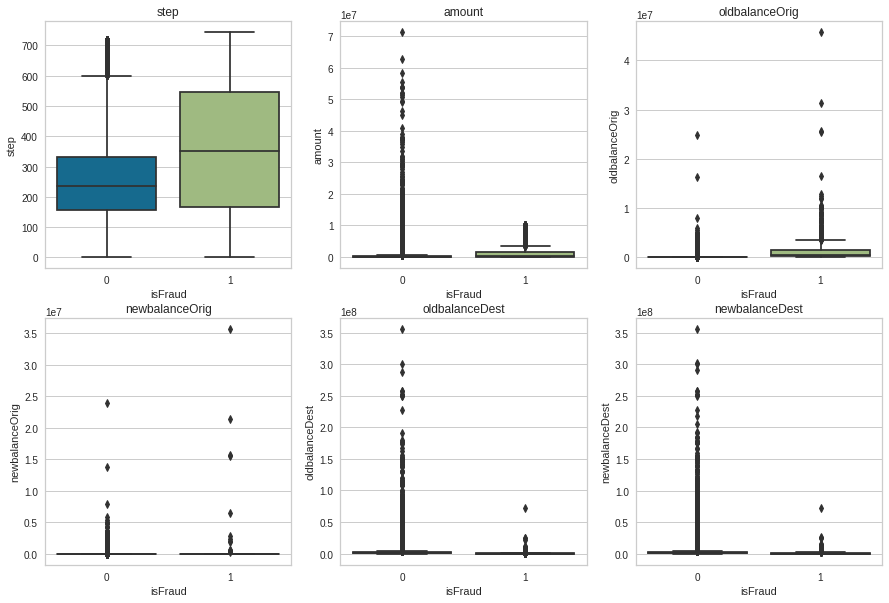

In [10]:
data_type = data[data['type'].isin(['CASH_OUT', 'TRANSFER'])]
col_continuous = ['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(15, 10))
ax = axs.ravel()
for i in range(len(col_continuous)):
    sns.boxplot(x = 'isFraud', y = col_continuous[i], data = data_type, ax = ax[i]).set_title(col_continuous[i])
pass

The box plots of `step`, `amount` and `oldbalanceOrig` for different classes are different, so `step`, `amount` and `oldbalanceOrig` might be important variables in fraud detection. `newbalanceOrig` is closely related to `amount` and `oldbalanceOrig`, so it should be taken consideration even if its difference between classes is unclear. The trend for `oldbalanceDest` and `newbalanceDest` are not quite clear, so we can drop them out.

Zeros might represent missing values in this dataset. If `oldbalanceOrig` and `newbalanceOrig` are both zero while `amount` is not, the values of `oldbalanceOrig` and `newbalanceOrig` might be missing. So let's replace these values as nan.

`type` TRANSFER means that money is sent to a customer/fraudster, `type` CASH_OUT indicates that money is sent to a merchant who pays the customer/fraudster in cash. Based on the definition, `amount`, `oldbalanceOrig` and `newbalanceOrig` should be perfectly correlated with relationship `amount` + `newbalanceOrig` = `oldbalanceOrig`. However, for most of the samples, this is not the case.

In [11]:
print('Proportion of perfectly correlated samples: {}%'.\
      format(round(data_type[data_type['amount'] + data_type['newbalanceOrig'] == data_type['oldbalanceOrig']].size/data_type.size*100, 2)))

Proportion of perfectly correlated samples: 8.98%


Thus we can construct a new variable called `errorbalanceOrig` which is defined as `newbalanceOrig` + `amount` - `oldbalanceOrig`.

# Data Cleaning

In [12]:
X = data.drop(['nameOrig', 'nameDest', 'isFraud'], axis = 1).copy()
y = data['isFraud'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=0)

In [13]:
X_train.shape, X_test.shape

((509009, 7), (127253, 7))

### Filter Rows

In [14]:
# filter based on type
index_train = X_train['type'].isin(['CASH_OUT', 'TRANSFER'])
X_train, y_train = X_train[index_train], y_train[index_train]
index_test = X_test['type'].isin(['CASH_OUT', 'TRANSFER'])
X_test_type, y_test_type = X_test[index_test], y_test[index_test]

In [15]:
X_train.shape, X_test_type.shape

((221107, 7), (55307, 7))

In [16]:
X = pd.concat([X_train, X_test_type], axis = 0)
X.sample(5)

step      type     amount  oldbalanceOrig  newbalanceOrig  \
220778   186  CASH_OUT   44948.88        15257.00             0.0   
154991   154  CASH_OUT  110699.85            0.00             0.0   
330519   252  CASH_OUT    4723.87           55.00             0.0   
378632   280  CASH_OUT  129405.64        22033.00             0.0   
340278   255  CASH_OUT   82515.51        34095.22             0.0   

        oldbalanceDest  newbalanceDest  
220778     11240341.07     11285289.94  
154991       720516.45       831216.31  
330519            0.00         4723.87  
378632       198406.32       327811.96  
340278       401760.80       484276.31

### Drop Features

In [17]:
X = X.drop(['newbalanceDest', 'oldbalanceDest'], axis = 1)

### Replace Values

In [18]:
# categorical to numeric
X = pd.get_dummies(X, columns = ['type'], drop_first = True)

# nan
X.loc[(X['oldbalanceOrig'] == 0) & (X['newbalanceOrig'] == 0) & (X['amount'] != 0), 
      ['oldbalanceOrig', 'newbalanceOrig']] = np.nan

### Create New Features

In [19]:
X['errorbalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrig']
X.sample(5)

step      amount  oldbalanceOrig  newbalanceOrig  type_TRANSFER  \
494770   351    85590.78         15002.0             0.0              0   
435646   309  1814497.59             NaN             NaN              1   
513422   356   162826.74             NaN             NaN              0   
195951   178   428862.33         42278.0             0.0              0   
344886   257  1231258.40          9026.0             0.0              1   

        errorbalanceOrig  
494770          70588.78  
435646               NaN  
513422               NaN  
195951         386584.33  
344886        1222232.40

In this case, since `amount`, `oldbalanceOrig`, `newbalanceOrig` and `errorbalanceOrig` are perfectly correlated, we can drop `oldbalanceOrig` to avoid perfect multicollinearity.

In [20]:
X = X.drop('oldbalanceOrig', axis = 1)

### Missing Data

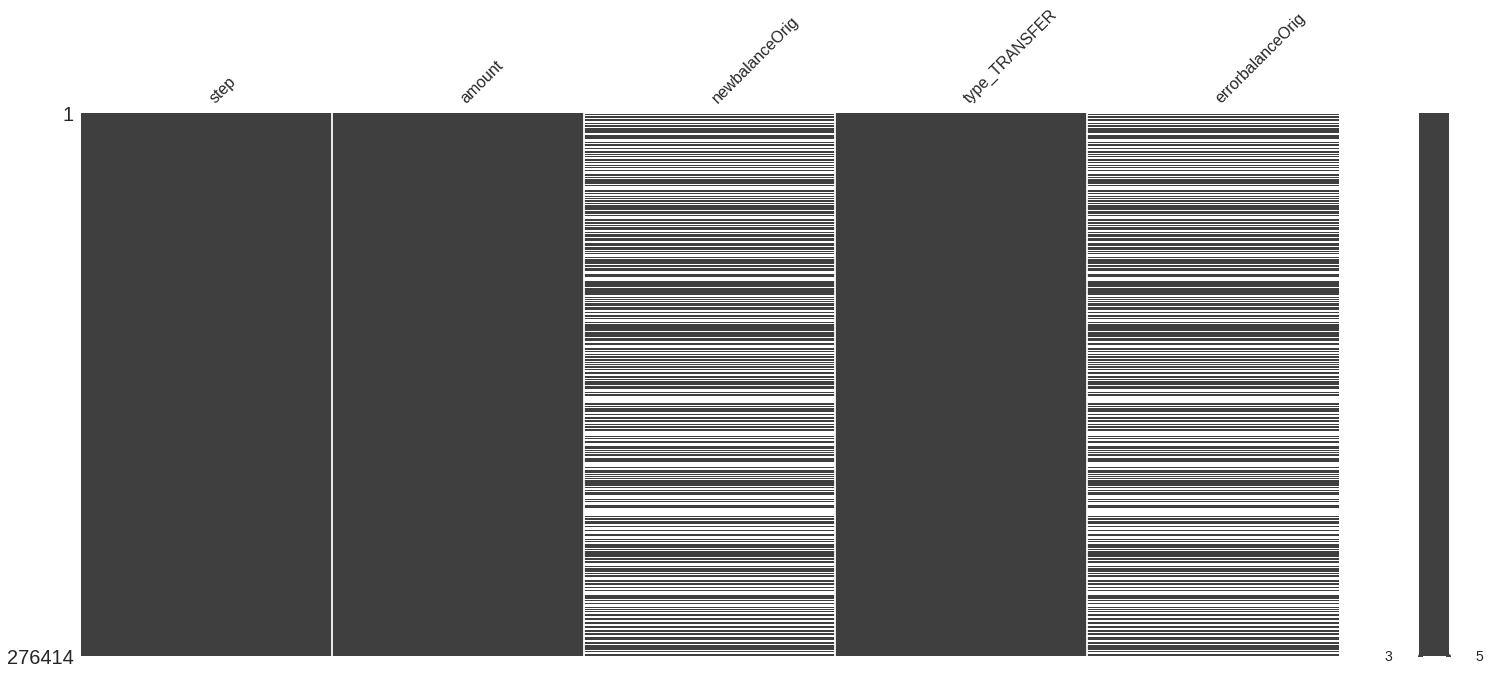

In [21]:
mn.matrix(X)
pass

We can apply fancy imputation to impute the missing values in `newbalanceOrig` and `errorbalanceOrig`. To avoid data leakage, we should firstly impute the training set and use the same model and parameters to impute testing set.

In [22]:
m = X_train.shape[0]
X_train = X.iloc[:m, :]
X_test_type = X.iloc[m:, :]

In [23]:
ii = IterativeImputer(random_state=0)
X_train_impute = ii.fit_transform(X_train)
X_test_type_impute = ii.transform(X_test_type)

In [24]:
print('Number of missing values in the training set:', np.isnan(X_train_impute).sum())
print('Number of missing values in the testing set:', np.isnan(X_test_type_impute).sum())

Number of missing values in the training set: 0
Number of missing values in the testing set: 0


# Models

`pycaret` is a great package to start with. We can narrow down the range of classification models that work well on our dataset and use them to construct a stacking classifier. `pycaret` will cope with imbalanced data problem automatically.

In [25]:
clfs = setup(
    data = pd.concat([X_train, y_train], axis = 1),
    target = 'isFraud',
    silent = True,
    session_id = 1
)

Setup Succesfully Completed!


To find the best model, we need to use evaluation metrics that are less sensitive to imbalance like F1 score.

In [26]:
best_model = compare_models(sort = 'F1')

We will test the first $5$ models shown above. And the F1 score will include the predictions where type is 'CASH_IN', 'DEBIT' or 'PAYMENT'.

In [27]:
index_pred = X_test['type'].isin(['CASH_OUT', 'TRANSFER'])
# transform array to data frame
X_train_impute = pd.DataFrame(X_train_impute, columns = X_train.columns)
X_test_type_impute = pd.DataFrame(X_test_type_impute, columns = X_train.columns)

### CatBoost Classifier

In [28]:
weights = (y == 0).sum()/(y == 1).sum()
clf_catboost = CatBoostClassifier(class_weights = {0: 1, 1: weights}, silent = True)
pred = clf_catboost.fit(X_train, y_train).predict(X_test_type)

In [29]:
pred_catboost = np.zeros(len(y_test))
pred_catboost[index_pred] = pred
f1_catboost = f1_score(pred_catboost, y_test)

In [30]:
f1_catboost

0.9828571428571428

### Light Gradient Boosting Machine

In [31]:
clf_lightgbm = LGBMClassifier(class_weight = {0: 1, 1: weights})
pred = clf_lightgbm.fit(X_train_impute, y_train).predict(X_test_type_impute)

In [32]:
pred_lightgbm = np.zeros(len(y_test))
pred_lightgbm[index_pred] = pred
f1_lightgbm = f1_score(pred_lightgbm, y_test)

In [33]:
f1_lightgbm

0.9855072463768114

### Decision Tree Classifier

In [34]:
clf_dt = DecisionTreeClassifier(random_state = 0, class_weight = {0: 1, 1: weights})
pred = clf_dt.fit(X_train_impute, y_train).predict(X_test_type_impute)

In [35]:
pred_dt = np.zeros(len(y_test))
pred_dt[index_pred] = pred
f1_dt = f1_score(pred_dt, y_test)

In [36]:
f1_dt

0.9971014492753623

### Random Forest Classifier

In [37]:
clf_rf = RandomForestClassifier(random_state = 0, n_jobs = -1, class_weight = {0: 1, 1: weights})
pred = clf_rf.fit(X_train_impute, y_train).predict(X_test_type_impute)

In [38]:
pred_rf = np.zeros(len(y_test))
pred_rf[index_pred] = pred
f1_rf = f1_score(pred_rf, y_test)

In [39]:
f1_rf

1.0

### Extreme Gradient Boosting

In [40]:
clf_xgboost = XGBClassifier(scale_pos_weight = weights, n_jobs = -1, max_depth = 3)
pred = clf_xgboost.fit(X_train_impute, y_train).predict(X_test_type_impute)

In [41]:
pred_xgboost = np.zeros(len(y_test))
pred_xgboost[index_pred] = pred
f1_xgboost = f1_score(pred_xgboost, y_test)

In [42]:
f1_xgboost

1.0

### Summary

In [43]:
print('F1 score for CatBoost Classifier:', f1_catboost)
print('F1 score for Light Gradient Boosting Machine:', f1_lightgbm)
print('F1 score for Decision Tree Classifier:', f1_dt)
print('F1 score for Random Forest Classifier:', f1_rf)
print('F1 score for Extreme Gradient Boosting:', f1_xgboost)

F1 score for CatBoost Classifier: 0.9828571428571428
F1 score for Light Gradient Boosting Machine: 0.9855072463768114
F1 score for Decision Tree Classifier: 0.9971014492753623
F1 score for Random Forest Classifier: 1.0
F1 score for Extreme Gradient Boosting: 1.0


Therefore, in terms of F1 score, Random Forest Classifier and Extreme Gradient Boosting have the best performance.

### Visualization

**Random Forest Classifier**

Confusion Matrix

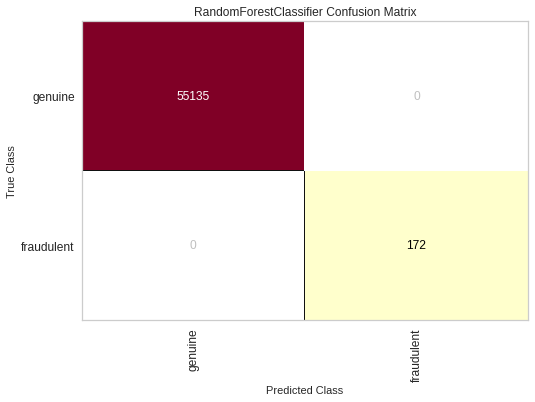

In [44]:
cm_viz = ConfusionMatrix(clf_rf, classes = ['genuine', 'fraudulent'])
cm_viz.fit(X_train_impute, y_train)
cm_viz.score(X_test_type_impute, y_test_type)
cm_viz.show()
pass

Learning Curve

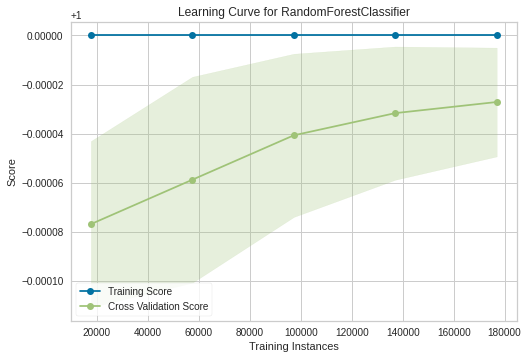

In [45]:
lc_viz = LearningCurve(clf_rf)
lc_viz.fit(X_train_impute, y_train)
lc_viz.score(X_test_type_impute, y_test_type)
lc_viz.show()
pass

Feature Importance

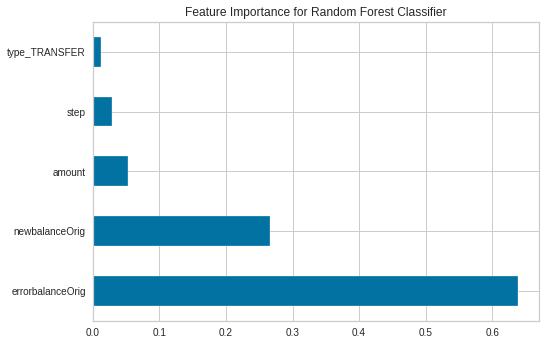

In [46]:
df_importance = pd.DataFrame(data = clf_rf.feature_importances_, 
                             index = X_train.columns, 
                             columns = ["score"]).sort_values(by = "score", ascending = False)
df_importance.plot(kind = 'barh', legend = None, title = 'Feature Importance for Random Forest Classifier')
pass

**Extreme Gradient Boosting**

Confusion Matrix

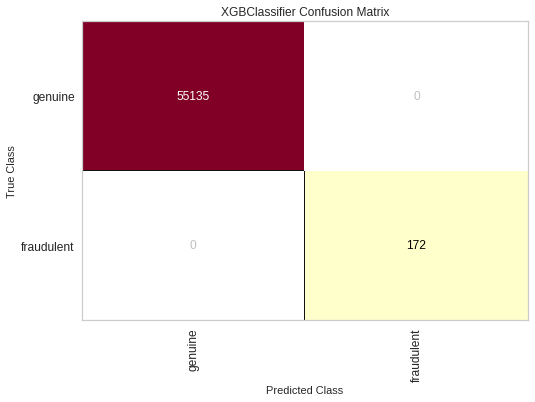

In [47]:
cm_viz = ConfusionMatrix(clf_xgboost, classes = ['genuine', 'fraudulent'])
cm_viz.fit(X_train_impute, y_train)
cm_viz.score(X_test_type_impute, y_test_type)
cm_viz.show()
pass

Learning Curve

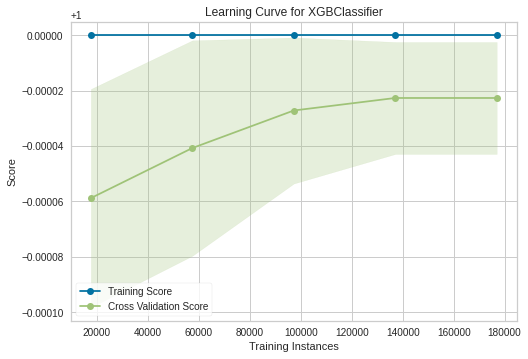

In [48]:
lc_viz = LearningCurve(clf_xgboost)
lc_viz.fit(X_train_impute, y_train)
lc_viz.score(X_test_type_impute, y_test_type)
lc_viz.show()
pass

Feature Importance

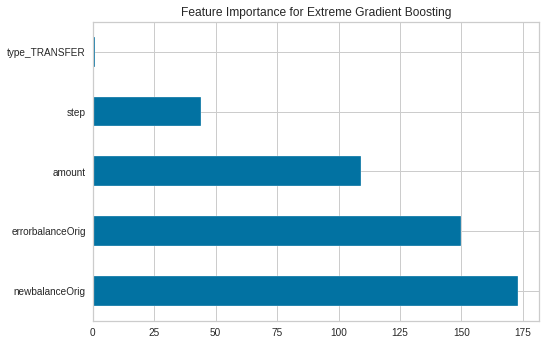

In [49]:
feature_important = clf_xgboost.get_booster().get_score(importance_type = 'weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data = values, 
                    index = keys, 
                    columns = ["score"]).sort_values(by = "score", ascending = False)
data.plot(kind = 'barh', legend = None, title = 'Feature Importance for Extreme Gradient Boosting')
pass

The confusion matrix is exactly the same for Random Forest Classifier and Extreme Gradient Boosting. Neither of them has errors and the number of positive accurate samples and negative accurate samples are the same as well.

According to the learning curve, Extreme Gradient Boosting will perform better than Random Forest Classifier when there is only limited number of samples. This is due to the fact that the cross validation score of Random Forest Classifier is still increasing when we reach the limit of the training samples. Therefore, the Random Forest model can be possibly improved by collecting more data.

The Feature Importance plot is very similar between Random Forest Classifier and Extreme Gradient Boosting. The only difference occurs in the rank of `errorbalanceOrig` and `newbalanceOrig`. For Random Forest Classifier, `errorbalanceOrig` is more important than `newbalanceOrig`. Conversely, for Extreme Gradient Boosting, `newbalanceOrig` is more significant than `errorbalanceOrig`. Their importance ranks for all the other features are the same.